[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This notebook uses legacy versions of ByteTrack and Supervision. To be up to date, use our updated [notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8-and-supervison.ipynb).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Nov 25 06:45:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
import requests
import urllib.parse
import google.colab
import os

google.colab.drive.mount('/content/drive')

Mounted at /content/drive


## Download video

In [ ]:
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/GoogleColab/KRA-2-7-2023-08-23-evening.mp4"

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.217 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.2.0



from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.2.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.core import Point
from supervision.video import VideoInfo
from supervision.video import get_video_frames_generator
from supervision.video import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision import Detections, BoxAnnotator
#from supervision. import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "/content/drive/MyDrive/GoogleColab/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Predict and annotate single frame

In [ ]:
import cv2

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [1, 2, 4]

LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

In [ ]:
import numpy as np
import supervision as sv


0: 384x640 3 buss, 3 cars, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


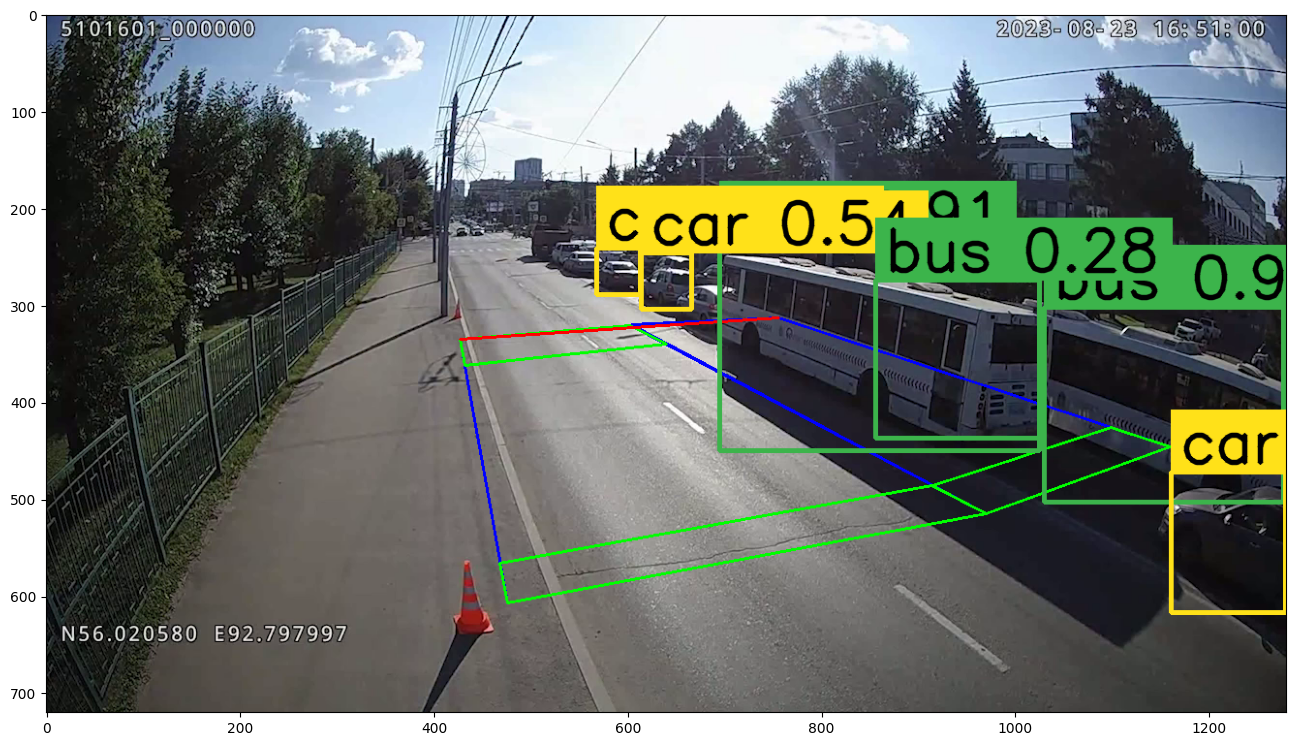

In [ ]:

data = {
    "areas": [
        [
            [0.371875, 0.8435185185185186],
            [0.3338541666666667, 0.46574074074074073],
            [0.4713541666666667, 0.4462962962962963],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.47239583333333335, 0.4444444444444444],
            [0.590625, 0.4351851851851852],
            [0.9067708333333333, 0.6203703703703703]
        ]
    ],
    "zones": [

        [
            [0.3338541666666667, 0.46574074074074073],
            [0.3375, 0.5027777777777778],
            [0.5, 0.47314814814814815],
            [0.4713541666666667, 0.4462962962962963],
        ],
        [
            [0.371875, 0.8435185185185186],
            [0.36614583333333334, 0.7861111111111111],
            [0.7145833333333333, 0.675],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.7151041666666667, 0.675],
            [0.8588541666666667, 0.5925925925925926],
            [0.9067708333333333, 0.6203703703703703]
        ],
        [
            [0.47239583333333335, 0.4444444444444444],
            [0.5005208333333333, 0.47129629629629627],
            [0.621875, 0.4537037037037037],
            [0.590625, 0.4351851851851852]
        ]
    ]
}


# Создание массива вершин полигонов из данных
polygons = []
zones = []

video_resolution = (1280, 720)

p1 = ((0.590625*np.array(video_resolution)).astype(int)[0],(0.4351851851851852*np.array(video_resolution)).astype(int)[1])
p2 = ((0.3338541666666667*np.array(video_resolution)).astype(int)[0],(0.46574074074074073*np.array(video_resolution)).astype(int)[1])

for area in data["areas"]:
    polygon = np.array(area) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    polygons.append(polygon)
for zone in data["zones"]:
    polygon = np.array(zone) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    zones.append(polygon)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
cv2.polylines(frame, polygons, isClosed=True, color=(255, 0, 0), thickness=2)
cv2.polylines(frame, zones, isClosed=True, color=(0, 255, 0), thickness=2)
cv2.line(frame, p1, p2, color=(0,0,255), thickness=2)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


0: 736x1280 2 buss, 6 cars, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
[[     1150.4      465.87      1279.9      620.13     0.78199]
 [     649.95      268.21      697.62      330.61     0.70879]
 [     564.51      249.78      614.88      294.33      0.6474]
 [     538.35      237.99      569.09      271.48     0.39833]
 [     629.09      252.77      667.77      305.28     0.37284]
 [     527.95       232.4      549.45      267.39     0.34947]]


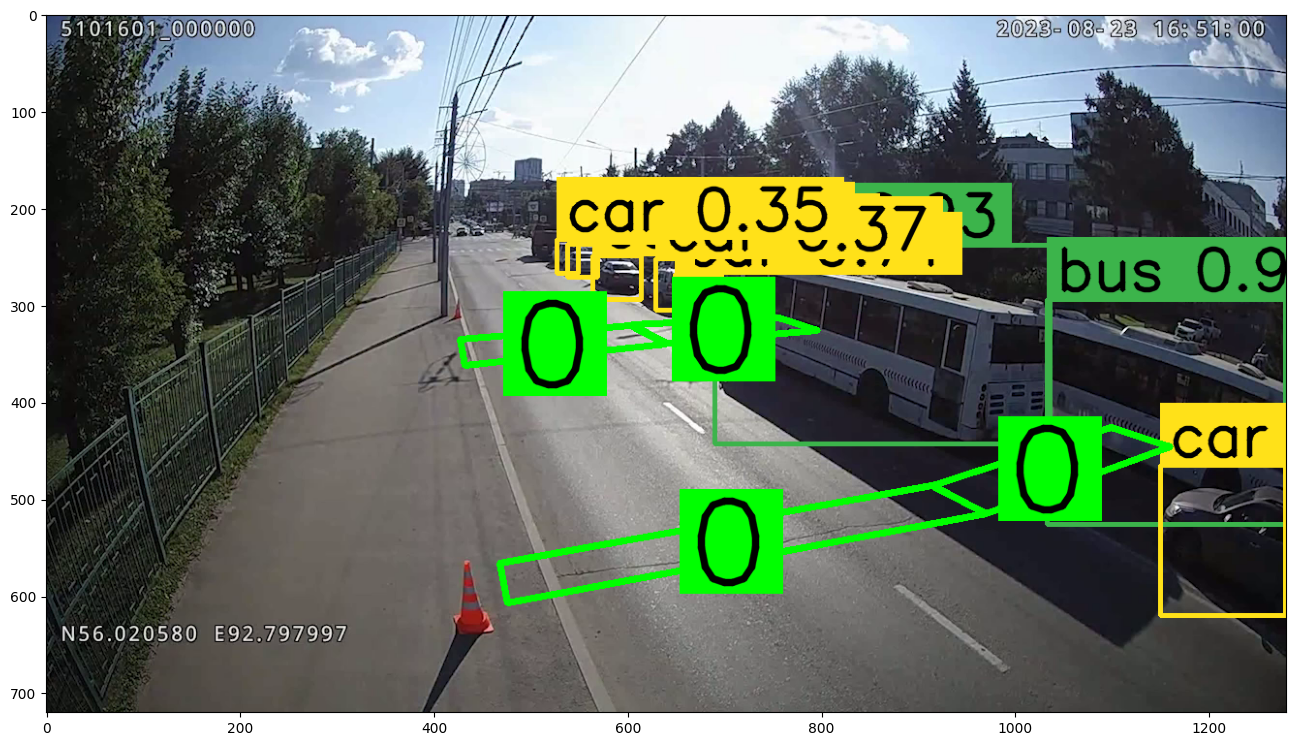

In [ ]:


# initiate polygon zone
data = {
    "areas": [
        [
            [0.371875, 0.8435185185185186],
            [0.3338541666666667, 0.46574074074074073],
            [0.4713541666666667, 0.4462962962962963],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.47239583333333335, 0.4444444444444444],
            [0.590625, 0.4351851851851852],
            [0.9067708333333333, 0.6203703703703703]
        ]
    ],
    "zones": [
        [
            [0.3338541666666667, 0.46574074074074073],
            [0.3375, 0.5027777777777778],
            [0.5, 0.47314814814814815],
            [0.4713541666666667, 0.4462962962962963]
        ],
        [
            [0.371875, 0.8435185185185186],
            [0.36614583333333334, 0.7861111111111111],
            [0.7145833333333333, 0.675],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.7151041666666667, 0.675],
            [0.8588541666666667, 0.5925925925925926],
            [0.9067708333333333, 0.6203703703703703]
        ],
        [
            [0.47239583333333335, 0.4444444444444444],
            [0.5005208333333333, 0.47129629629629627],
            [0.621875, 0.4537037037037037],
            [0.590625, 0.4351851851851852]
        ]
    ]
}

# Создание массива вершин полигонов из данных
polygons = []
zones = []
video_resolution = (1280, 720)
for area in data["areas"]:
    polygon = np.array(area) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    polygons.append(polygon)
for zone in data["zones"]:
    polygon = np.array(zone) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    zones.append(polygon)

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

zone1_enter_cars = sv.PolygonZone(polygon=zones[0], frame_resolution_wh=video_info.resolution_wh)
zone1_enter_vans = sv.PolygonZone(polygon=zones[0], frame_resolution_wh=video_info.resolution_wh)
zone1_enter_bus = sv.PolygonZone(polygon=zones[0], frame_resolution_wh=video_info.resolution_wh)

zone1_exit_cars = sv.PolygonZone(polygon=zones[1], frame_resolution_wh=video_info.resolution_wh)
zone1_exit_vans = sv.PolygonZone(polygon=zones[1], frame_resolution_wh=video_info.resolution_wh)
zone1_exit_bus = sv.PolygonZone(polygon=zones[1], frame_resolution_wh=video_info.resolution_wh)

zone2_enter_cars = sv.PolygonZone(polygon=zones[2], frame_resolution_wh=video_info.resolution_wh)
zone2_enter_vans = sv.PolygonZone(polygon=zones[2], frame_resolution_wh=video_info.resolution_wh)
zone2_enter_bus = sv.PolygonZone(polygon=zones[2], frame_resolution_wh=video_info.resolution_wh)

zone2_exit_cars = sv.PolygonZone(polygon=zones[3], frame_resolution_wh=video_info.resolution_wh)
zone2_exit_vans = sv.PolygonZone(polygon=zones[3], frame_resolution_wh=video_info.resolution_wh)
zone2_exit_bus = sv.PolygonZone(polygon=zones[3], frame_resolution_wh=video_info.resolution_wh)



# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator1 = sv.PolygonZoneAnnotator(zone=zone1_enter_cars, color=sv.Color.green(), thickness=6, text_thickness=6, text_scale=4)
zone_annotator2 = sv.PolygonZoneAnnotator(zone=zone2_enter_cars, color=sv.Color.green(), thickness=6, text_thickness=6, text_scale=4)
zone_annotator3 = sv.PolygonZoneAnnotator(zone=zone1_exit_cars, color=sv.Color.green(), thickness=6, text_thickness=6, text_scale=4)
zone_annotator4 = sv.PolygonZoneAnnotator(zone=zone2_exit_cars, color=sv.Color.green(), thickness=6, text_thickness=6, text_scale=4)


# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
car_detections = detections[detections.class_id == 2]
van_detections = detections[detections.class_id == 4]
bus_detections = detections[detections.class_id == 1]
print(detections2boxes(car_detections))

zone1_enter_bus.trigger(detections=bus_detections)
zone1_enter_vans.trigger(detections=van_detections)
zone1_enter_cars.trigger(detections=car_detections)

zone1_exit_bus.trigger(detections=bus_detections)
zone1_exit_vans.trigger(detections=van_detections)
zone1_exit_cars.trigger(detections=car_detections)

zone2_enter_bus.trigger(detections=bus_detections)
zone2_enter_vans.trigger(detections=van_detections)
zone2_enter_cars.trigger(detections=car_detections)

zone1_exit_bus.trigger(detections=bus_detections)
zone1_exit_vans.trigger(detections=van_detections)
zone1_exit_cars.trigger(detections=car_detections)

#print("Cars " + str(zone1_cars.current_count) + " " + str(zone2_cars.current_count) + "\n"
#"Vans " + str(zone1_vans.current_count) + " " + str(zone2_vans.current_count) + "\n"
#"Bus " + str(zone1_bus.current_count) + " " + str(zone2_bus.current_count) + "\n"
#)
# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator1.annotate(scene=frame)
frame = zone_annotator2.annotate(scene=frame)
frame = zone_annotator3.annotate(scene=frame)
frame = zone_annotator4.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point((0.590625*np.array(video_resolution)).astype(int)[0],(0.4351851851851852*np.array(video_resolution)).astype(int)[1])
LINE_END = Point((0.3338541666666667*np.array(video_resolution)).astype(int)[0],(0.46574074074074073*np.array(video_resolution)).astype(int)[1])

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
import csv
def startup_csv(file):
    with open(file, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(
            ["file_name",
             "quantity_car",
             "average_speed_car",
             "quantity_van",
             "average_speed_van",
             "quantity_bus",
             "average_speed_bus"
             ])
startup_csv(f"{HOME}/result.csv")

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=36001)

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import supervision as sv

data = {
    "areas": [
        [
            [0.371875, 0.8435185185185186],
            [0.3338541666666667, 0.46574074074074073],
            [0.4713541666666667, 0.4462962962962963],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.47239583333333335, 0.4444444444444444],
            [0.590625, 0.4351851851851852],
            [0.9067708333333333, 0.6203703703703703]
        ]
    ],
    "zones": [
        [
            [0.3338541666666667, 0.46574074074074073],
            [0.3375, 0.5027777777777778],
            [0.5, 0.47314814814814815],
            [0.4713541666666667, 0.4462962962962963]
        ],
        [
            [0.371875, 0.8435185185185186],
            [0.36614583333333334, 0.7861111111111111],
            [0.7145833333333333, 0.675],
            [0.7578125, 0.7157407407407408]
        ],
        [
            [0.7583333333333333, 0.7157407407407408],
            [0.7151041666666667, 0.675],
            [0.8588541666666667, 0.5925925925925926],
            [0.9067708333333333, 0.6203703703703703]
        ],
        [
            [0.47239583333333335, 0.4444444444444444],
            [0.5005208333333333, 0.47129629629629627],
            [0.621875, 0.4537037037037037],
            [0.590625, 0.4351851851851852]
        ]
    ]
}


# Создание массива вершин полигонов из данных
polygons = []
zones = []

video_resolution = (1280, 720)

for area in data["areas"]:
    polygon = np.array(area) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    polygons.append(polygon)
for zone in data["zones"]:
    polygon = np.array(zone) * np.array(video_resolution)  # Масштабирование координат под разрешение кадра
    polygon = polygon.astype(int)  # Преобразование координат в целые числа
    zones.append(polygon)


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

zone1_enter_cars = sv.PolygonZone(polygon=zones[0], frame_resolution_wh=video_info.resolution_wh)
zone1_exit_cars = sv.PolygonZone(polygon=zones[1], frame_resolution_wh=video_info.resolution_wh)
zone2_enter_cars = sv.PolygonZone(polygon=zones[2], frame_resolution_wh=video_info.resolution_wh)
zone2_exit_cars = sv.PolygonZone(polygon=zones[3], frame_resolution_wh=video_info.resolution_wh)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator1 = sv.PolygonZoneAnnotator(zone=zone1_enter_cars, color=sv.Color.green(), thickness=4, text_thickness=4, text_scale=2)
zone_annotator2 = sv.PolygonZoneAnnotator(zone=zone2_enter_cars, color=sv.Color.green(), thickness=4, text_thickness=4, text_scale=2)
zone_annotator3 = sv.PolygonZoneAnnotator(zone=zone1_exit_cars, color=sv.Color.green(), thickness=4, text_thickness=4, text_scale=2)
zone_annotator4 = sv.PolygonZoneAnnotator(zone=zone2_exit_cars, color=sv.Color.green(), thickness=4, text_thickness=4, text_scale=2)

cars = {}
vans = {}
buss = {}

def empty(x):
  return
# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        z1n = zone1_enter_cars.trigger(detections=detections)
        z1x = zone1_exit_cars.trigger(detections=detections)
        z2n = zone2_enter_cars.trigger(detections=detections)
        z2x = zone2_exit_cars.trigger(detections=detections)

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        i = 0
        for xyxy, confidence, class_id, tracker_id in detections:
          if CLASS_NAMES_DICT[class_id] == "car":
            try:
              empty(cars[tracker_id])
              if(z1n[i]):
                cars[tracker_id][1] = xyxy
              if(z1x[i]):
                cars[tracker_id][2] = xyxy
              if(z2n[i]):
                cars[tracker_id][1] = xyxy
              if(z2x[i]):
                cars[tracker_id][2] = xyxy
              cars[tracker_id][0] = cars[tracker_id][0] + 1
            except:
              cars[tracker_id] = [0,None,None]

          if CLASS_NAMES_DICT[class_id] == "van":
            try:
              empty(vans[tracker_id])
              if(z1n[i]):
                vans[tracker_id][1] = xyxy
              if(z1x[i]):
                vans[tracker_id][2] = xyxy
              if(z2n[i]):
                vans[tracker_id][1] = xyxy
              if(z2x[i]):
                vans[tracker_id][2] = xyxy
              vans[tracker_id][0] = vans[tracker_id][0] + 1
            except:
              vans[tracker_id] = [0,None,None]

          if CLASS_NAMES_DICT[class_id] == "bus":
            try:
              empty(buss[tracker_id])
              if(z1n[i]):
                buss[tracker_id][1] = xyxy
              if(z1x[i]):
                buss[tracker_id][2] = xyxy
              if(z2n[i]):
                buss[tracker_id][1] = xyxy
              if(z2x[i]):
                buss[tracker_id][2] = xyxy
              buss[tracker_id][0] = buss[tracker_id][0] + 1
            except:
              buss[tracker_id] = [0,None,None]
          i+=1

        # annotate and display frame
        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        zone_annotator1.annotate(scene=frame)
        zone_annotator2.annotate(scene=frame)
        zone_annotator3.annotate(scene=frame)
        zone_annotator4.annotate(scene=frame)
        sink.write_frame(frame)

def focus_time(frames_in_focus, fps):
    return frames_in_focus/fps

import math
def speed(enterpoint, exitpoint, time_in_focus, first_conus_position, secon_conus_position, real_conus_length):
    y0 = abs(enterpoint[1] - exitpoint[1])
    Lpx = math.sqrt(pow(first_conus_position[0] - secon_conus_position[0],2)+pow(first_conus_position[1] - secon_conus_position[1],2))
    Lm = real_conus_length

    u0 = Lpx / Lm
    X = y0/u0
    T = time_in_focus
    return X * 3.6 / T
import csv
def save_to_csv(file, video_name, cars_speed, vans_speed, bus_speeds):
    with open(file, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(
            [video_name,
             len(cars_speed), "{:.2f}".format(sum(cars_speed)/(len(cars_speed)+1)),
             len(vans_speed), "{:.2f}".format(sum(vans_speed)/(len(vans_speed)+1)),
             len(bus_speeds), "{:.2f}".format(sum(bus_speeds)/(len(bus_speeds)+1))
             ])

def center(xyxy):
  return (xyxy[2]-xyxy[1],xyxy[3]-xyxy[1])

fps = 30
con_len = 20
conus_pos1 = data["zones"][0][0]
conus_pos2 = data["zones"][1][0]
cars_speed = []
vans_speed = []
bus_speeds = []

for key, value in cars.items():
  if value[1] is None or value[2] is None:
    continue
  entry = center(value[1])
  exit = center(value[2])
  temp = speed(entry, exit, focus_time(value[0], fps), conus_pos1, conus_pos2, con_len)/78
  cars_speed.append(temp)

for key, value in vans.items():
  if value[1] is None or value[2] is None:
    continue
  entry = center(value[1])
  exit = center(value[2])
  temp = speed(entry, exit, focus_time(value[0], fps), conus_pos1, conus_pos2, con_len)/78
  vans_speed.append(temp)

for key, value in buss.items():
  if value[1] is None or value[2] is None:
    continue
  entry = center(value[1])
  exit = center(value[2])
  temp = speed(entry, exit, focus_time(value[0], fps), conus_pos1, conus_pos2, con_len)/78
  bus_speeds.append(temp)

save_to_csv(f"{HOME}/result.csv", TARGET_VIDEO_PATH.split('/')[-1], cars_speed, vans_speed, bus_speeds)

  0%|          | 0/36001 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 4 cars, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 14.0ms
Speed: 2.9ms preprocess, 14.0ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.6ms postproc

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.